# Age prediction using photo and CNN

## 1. Initialization

In [1]:
#necessary libraries
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
#load labels.csv and observe it
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
# create datagenerator object for training and validation datasets
#rescale images using 1/255
train_datagen = ImageDataGenerator(rescale=1 / 255)
#use flow_from_dataframe method to load images from directory and labels from dataframe
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory='/datasets/faces/final_files/',
    x_col="file_name", 
    y_col="real_age",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",
    target_size=(224, 224), 
    batch_size=32,
    seed=12345,
    )


Found 7591 validated image filenames.


## 3. EDA

### 3.1 Age distribution

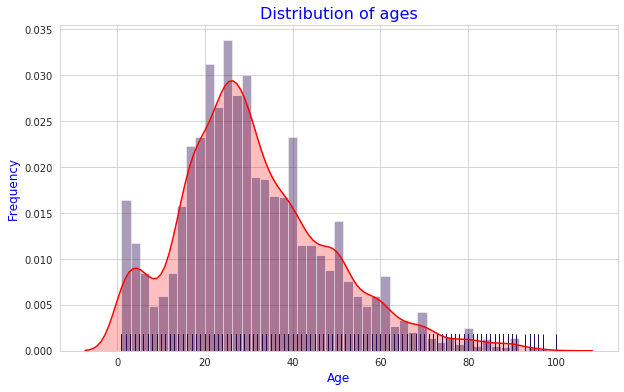

In [4]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of ages', fontsize=16, color='b')
plt.show()

As we can see from the above plot, we have images of people of various ages. However, the majority of the images belong to 20-40 years old people. And also we have pretty much cute baby photos (less than 10).

### 3.2 Random photos

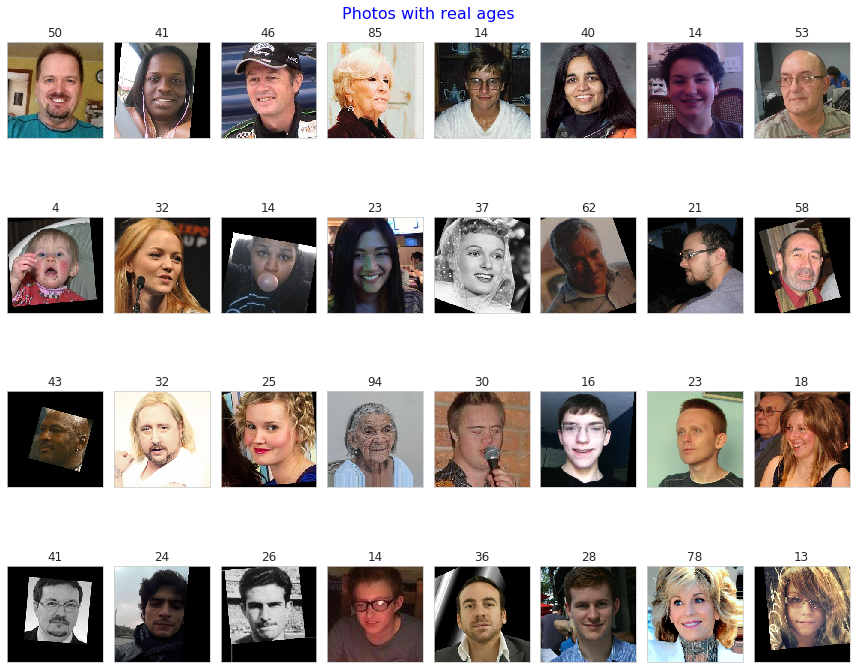

In [5]:
#get one batch from our datagenerator and display images in it
features, target = next(train_datagen_flow)

# display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with real ages', y=0.9, fontsize=16, color='b')
    plt.tight_layout()

### 3.3 Without face images

In [6]:
#following images does not have/or not good image photos
files =['/datasets/faces/final_files/000025.jpg',
       '/datasets/faces/final_files/000049.jpg',
       '/datasets/faces/final_files/000095.jpg',
       '/datasets/faces/final_files/000100.jpg']

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


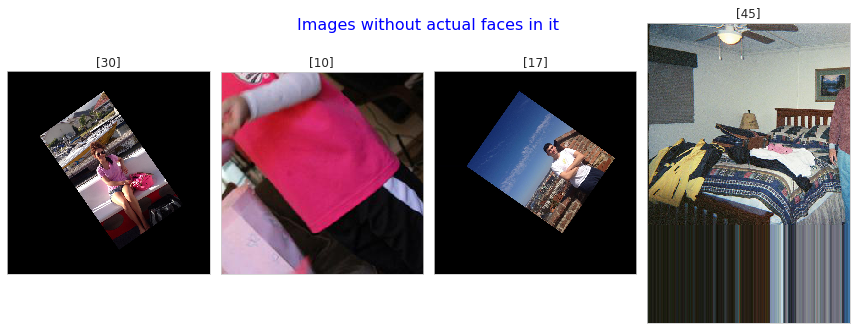

In [7]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(1, 4, i+1)
    image = Image.open(files[i])
    array = np.array(image)
    plt.imshow(array)
    file_name = files[i].split('/')[-1]
    title = labels[labels['file_name'] == file_name]['real_age'].values
    
    plt.title(title)
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Images without actual faces in it', y=0.68, fontsize=16, color='b')
    plt.tight_layout()

### 3.4 Findings

Wow, we have around 7.6k face photos from various aged people. We can see that some of the images are already rotated, shifted, etc (augmentations). However, we have observed that there are some images, actually, there are no face or face is not clear! But they have labels. e.g. the second photo above, says it is 10 years old. Really :) So, such kind of flaws can lead to wrong predictions. Nevertheless, we will not deal with such an issue for now.

## 4. Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [8]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [9]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345
        )

    return train_gen_flow

In [10]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe = labels,
        directory=path +'final_files/',
        x_col="file_name",
        y_col="real_age", 
        class_mode="raw", 
        target_size=(224,224), 
        batch_size=32,
        subset = "validation",
        seed=12345,
        )

    return test_gen_flow

In [11]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    return model

In [12]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)

    return model

## 5. Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [13]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### 5.1 Output

Place the output from the GPU platform as an Markdown cell here.

#### 5.1.1 Model summary

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Model: "sequential"



|Layer (type)                |Output Shape          | Param #     |
|----------------------------|----------------------|-------------|
|resnet50 (Model)            |(None, 7, 7, 2048)    | 23587712    |
|dropout (Dropout)           |(None, 7, 7, 2048)    | 0           |
|global_average_pooling2d (Gl|(None, 2048)          | 0           |
|dense (Dense)               |(None, 1)             | 2049        |


Total params: 23,589,761

Trainable params: 23,536,641

Non-trainable params: 53,120


Train for 178 steps, validate for 60 steps

#### 5.1.2 Ouput

Epoch 1/20

178/178 - 137s - loss: 10.2844 - mae: 10.2846 - val_loss: 15.7362 - val_mae: 15.7140

Epoch 2/20

178/178 - 36s - loss: 7.4201 - mae: 7.4204 - val_loss: 22.1354 - val_mae: 22.1359

Epoch 3/20

178/178 - 36s - loss: 6.4563 - mae: 6.4567 - val_loss: 16.7300 - val_mae: 16.7169

Epoch 4/20

178/178 - 36s - loss: 5.8888 - mae: 5.8894 - val_loss: 11.3083 - val_mae: 11.2725

Epoch 5/20

178/178 - 36s - loss: 5.1811 - mae: 5.1814 - val_loss: 7.5926 - val_mae: 7.5840

Epoch 6/20

178/178 - 36s - loss: 4.6374 - mae: 4.6379 - val_loss: 8.5085 - val_mae: 8.5104

Epoch 7/20

178/178 - 36s - loss: 4.2857 - mae: 4.2853 - val_loss: 8.8672 - val_mae: 8.8742

Epoch 8/20

178/178 - 36s - loss: 4.0122 - mae: 4.0123 - val_loss: 7.7957 - val_mae: 7.8065

Epoch 9/20

178/178 - 36s - loss: 3.7306 - mae: 3.7309 - val_loss: 6.6707 - val_mae: 6.6974

Epoch 10/20

178/178 - 36s - loss: 3.5257 - mae: 3.5258 - val_loss: 6.2950 - val_mae: 6.3287

Epoch 11/20

178/178 - 36s - loss: 3.3449 - mae: 3.3449 - val_loss: 7.4111 - val_mae: 7.4547

Epoch 12/20

178/178 - 36s - loss: 3.0831 - mae: 3.0832 - val_loss: 6.9353 - val_mae: 6.9436

Epoch 13/20

178/178 - 36s - loss: 2.9521 - mae: 2.9521 - val_loss: 7.1718 - val_mae: 7.1965

Epoch 14/20

178/178 - 36s - loss: 2.7855 - mae: 2.7856 - val_loss: 7.2892 - val_mae: 7.3395

Epoch 15/20

178/178 - 36s - loss: 2.6895 - mae: 2.6896 - val_loss: 6.4216 - val_mae: 6.4486

Epoch 16/20

178/178 - 36s - loss: 2.5753 - mae: 2.5753 - val_loss: 6.8077 - val_mae: 6.8279

Epoch 17/20

178/178 - 36s - loss: 2.4553 - mae: 2.4554 - val_loss: 6.8543 - val_mae: 6.8653

Epoch 18/20

178/178 - 36s - loss: 2.4716 - mae: 2.4715 - val_loss: 6.2691 - val_mae: 6.2899

Epoch 19/20

178/178 - 36s - loss: 2.3704 - mae: 2.3705 - val_loss: 6.1003 - val_mae: 6.1290

Epoch 20/20

178/178 - 36s - loss: 2.2829 - mae: 2.2828 - val_loss: 6.7680 - val_mae: 6.7828

## 6 Summary

- Dataset containing 7.6k images has been loaded!
- There were photos for almost every age group (from 0 to 100). And its distribution was normal, where the highest proportion was coming from people aged between 20-40.
- Several images have been investigated and it was observed that the dataset contains images where there is no face is visible (such kind of errors has not been fixed for this project). Moreover, it was observed that images have various sizes (pixel size), however, during uploading, all of them were converted to (224, 224) pixel size.
- Neural network based on ResNet50 architecture has been created (which has more than 23 million trainable params) and trained with 75% of data and validated with the rest. With 20 epochs, an MAE of 6.8 (on validation set) has been achieved.

- Obtained model can predict the age of a person ±6.8. Even though it does not sound breakthrough, it is quite promising, especially when we compare it with the publication which achieved 5.4 MAE with the same dataset. Moreover, further fine-tuning the neural network can provide better results (particularly with a more correct dataset).